In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels as sm
import pmdarima as pm

In [2]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.index = np.arange(df.shape[0])
df.rename(columns=lambda c: str(c), inplace=True)

In [3]:
from datetime import datetime, timedelta

train = df.iloc[:300, :]
train.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(train.shape[0])]
test = df.iloc[300:, :]
test.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(test.shape[0])]

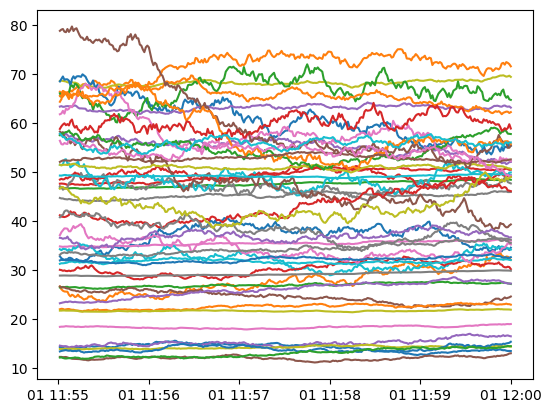

In [5]:
for col in train.columns:
    plt.plot(train[col])

In [6]:
# Find stationary series
for i in range(50):
    series = train[str(i)]
    res = sm.tsa.stattools.adfuller(series)
    if res[1] < 0.05:
        print(i, res)

7 (-3.0641872459434363, 0.02931953482001921, 0, 299, {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}, 245.60316139758368)
8 (-3.1166290521180517, 0.025346790204196473, 1, 298, {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}, -540.1946187928907)
28 (-3.0635749432403094, 0.029368894873173405, 3, 296, {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}, -483.1160804627716)
43 (-2.9975632396953453, 0.035122590513755436, 0, 299, {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}, 465.8173798665294)
46 (-3.2744947964003104, 0.016057770430221833, 0, 299, {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}, 201.40389453438797)
49 (-3.65050667979286, 0.004865704048235117, 7, 292, {'1%': -3.4529449243622383, '5%': -2.871489553425686, '10%': -2.572071437887033}, 62.84159518160459)


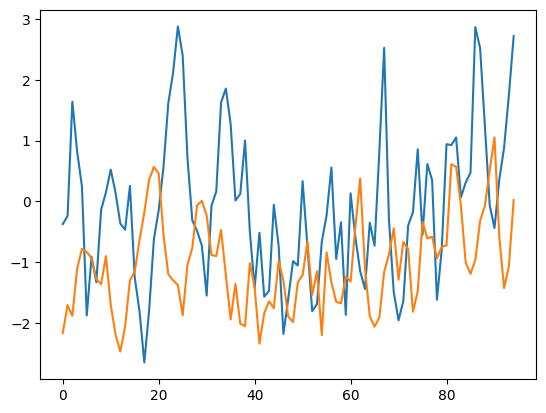

In [7]:
from lead_lag import lag
# Testing

ts = sm.tsa.arima_process.arma_generate_sample([1, -0.75, 0.25], [1], 100)
shifted = ts[5:] * 0.6 - 1 + np.random.randn(95) * 0.1
ts = ts[:-5]
plt.plot(ts)
plt.plot(shifted)



In [8]:
from datetime import datetime, timedelta

t = pd.Series(data=ts, index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(len(ts))])
s = pd.Series(data=shifted, index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(len(shifted))])

lag(t, s, max_lag=10)

5.0

In [8]:
import lead_lag

ll = lead_lag.LeadLag(
    ts1 = t,
    ts2 = s,
    max_lag = 20,
    verbose=True,
    min_precision=0.1
)
ll.run_inference()

Precision = 100.0 ms.
Running slow_inference() on (-200:200) with 1 thread.
Lag=-200, contrast=0.06176, elapsed=0.00ms.
Lag=-199, contrast=0.21496, elapsed=0.00ms.
Lag=-198, contrast=0.21496, elapsed=0.00ms.
Lag=-197, contrast=0.21496, elapsed=0.00ms.
Lag=-196, contrast=0.21496, elapsed=0.00ms.
Lag=-195, contrast=0.21496, elapsed=5.08ms.
Lag=-194, contrast=0.21496, elapsed=0.00ms.
Lag=-193, contrast=0.21496, elapsed=0.00ms.
Lag=-192, contrast=0.21496, elapsed=0.00ms.
Lag=-191, contrast=0.21496, elapsed=0.00ms.
Lag=-190, contrast=0.15320, elapsed=0.00ms.
Lag=-189, contrast=0.16899, elapsed=3.06ms.
Lag=-188, contrast=0.16899, elapsed=0.00ms.
Lag=-187, contrast=0.16899, elapsed=0.00ms.
Lag=-186, contrast=0.16899, elapsed=0.00ms.
Lag=-185, contrast=0.16899, elapsed=2.07ms.
Lag=-184, contrast=0.16899, elapsed=0.20ms.
Lag=-183, contrast=0.16899, elapsed=0.00ms.
Lag=-182, contrast=0.16899, elapsed=0.00ms.
Lag=-181, contrast=0.16899, elapsed=0.00ms.
Lag=-180, contrast=0.01579, elapsed=0.00ms.


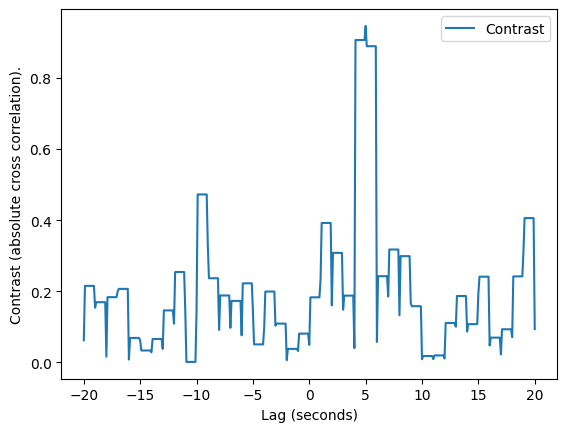

In [9]:
ll.plot_results()

In [6]:
train.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(train.shape[0])]

In [5]:
import lead_lag as ll

In [ ]:
results = {}
for i in range(50):
    for j in range(i+1, 50):
        t1, t2 = str(i), str(j)
        lag = ll.lag(train[t1], train[t2], max_lag=50)
        lag = int(lag)
        # test for cointegration
        if lag > 0:
            # t1 leads t2, shift t1 forward

            pass
        elif lag < 0:
            # other way
            t1, t2 = t2, t1
            lag = -lag
        else:
            continue

        shiftt1 = train[t1][lag:]
        shiftt2 = train[t2][:-lag]
        res = sm.tsa.stattools.coint(shiftt1, shiftt2)
        corr = shiftt1.corr(shiftt2)
        results[t1,t2] = (res[1], corr, lag)


In [17]:

for pair, (value, corr, lag) in results.items():
    if corr > 0.7:
        share1, share2 = pair
        standard1 = (test[share1] - test[share1].mean())/ test[share1].std()
        standard2 = (test[share2] - test[share2].mean())/ test[share2].std()
        shifted1 = pd.Series(np.array(standard1)[:-lag])
        shifted2 = pd.Series(np.array(standard2)[lag:])
        testCorr = shifted1.corr(shifted2)
        if testCorr > 0.7:
            print(pair, lag)
            print(value, corr, testCorr)

('2', '33') 2
0.4796375962361405 0.9148091011887786 0.7720420038848287
('3', '12') 13
0.25502821317628466 0.8788617446060846 0.7946666587835666
('18', '3') 13
0.033849983238854325 0.8761310130570511 0.7189788532608458
('3', '27') 12
0.9389244105604461 0.8573994193020216 0.7242812725024238
('40', '3') 24
0.5226005200267054 0.7896260528531459 0.8217550236980774
('15', '4') 10
0.5619180432268408 0.7506509536535183 0.7662180791998012
('19', '4') 21
0.9591044192924001 0.7154220780060542 0.7894964422606389
('35', '15') 22
0.7051657459659495 0.8551246375281802 0.7762413504146474
('16', '34') 1
0.3981176919383343 0.9263231818540706 0.8258909721587396
('32', '19') 27
0.23032184997225913 0.7325693455914405 0.7664488396930881
('22', '21') 40
0.3441497796613119 0.7078510837368139 0.7317190689015639
('23', '27') 20
0.7463786883520684 0.8122879135058481 0.909645430387255
('33', '23') 21
0.4546492836030602 0.8690918267871324 0.7206308437556749
('23', '42') 35
0.09255345842634699 0.8105944053371311 0.

In [6]:
# Try running it on the moving average for better result
results = {}
for i in range(50):
    for j in range(i+1, 50):
        t1, t2 = str(i), str(j)
        lag = ll.lag(train[t1].rolling(5).mean(), train[t2].rolling(5).mean(), max_lag=50)
        lag = int(lag)
        # test for cointegration
        if lag > 0:
            # t1 leads t2, shift t1 forward

            pass
        elif lag < 0:
            # other way
            t1, t2 = t2, t1
            lag = -lag
        else:
            continue

        shiftt1 = train[t1][lag:]
        shiftt2 = train[t2][:-lag]
        res = sm.tsa.stattools.coint(shiftt1, shiftt2)
        corr = shiftt1.corr(shiftt2)
        results[t1,t2] = (res[1], corr, lag)


In [8]:

for pair, (value, corr, lag) in results.items():
    if corr > 0.7:
        share1, share2 = pair
        standard1 = (test[share1] - test[share1].mean())/ test[share1].std()
        standard2 = (test[share2] - test[share2].mean())/ test[share2].std()
        shifted1 = pd.Series(np.array(standard1.rolling(5).mean())[:-lag])
        shifted2 = pd.Series(np.array(standard2.rolling(5).mean())[lag:])
        testCorr = shifted1.corr(shifted2)
        if testCorr > 0.7:
            print(pair, lag)
            print(value, corr, testCorr)

('33', '2') 1
0.5530688441929772 0.912386885896617 0.785519207003194
('18', '3') 3
0.01576850907753066 0.8942881158417011 0.7508235551711508
('40', '3') 4
0.5581838941066988 0.792162225925538 0.8465831243467311
('15', '4') 10
0.27419834182508884 0.7722289793529071 0.7863858332808714
('12', '33') 36
0.034149593209034386 0.9074583245661086 0.9035341772108045
('12', '42') 50
0.0933472684463515 0.8998502419120301 0.7316779025628201
('27', '14') 11
0.23468171968567775 0.7715789514996629 0.8765676508198627
('38', '14') 10
0.09444675005688241 0.7406952832498616 0.9146745364566384
('18', '17') 16
0.2822681868579355 0.7065313610924993 0.795261223037568
('19', '32') 6
0.26022420384011963 0.8103479499611728 0.7091783679834422
('23', '27') 23
0.5372498830635395 0.8428037047077335 0.9087830831211738
('23', '33') 42
0.6643094308644737 0.9256443200984809 0.8170859800197853
('23', '42') 32
0.4589853423076573 0.9329085874013856 0.7964842348649613
('25', '36') 22
0.03241446435822452 0.8079666450163084 0

In [13]:
from arbitragelab.cointegration_approach.minimum_profit import MinimumProfit


d:\AA_Apps\anaconda3\envs\algothon_env\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [ ]:
def analyze(t1, t2, lag):
    # t1 always leads

    shiftt1 = train[t1].shift(lag)[lag:]
    shiftt1_df = df[t1].shift(lag)[lag:]
    shiftt2 = train[t2][:-lag]
    shiftt2_df = df[t2][:-lag]

    res = sm.tsa.stattools.coint(shiftt1, shiftt2)

    # analyze shift
    opt = MinimumProfit()
    opt.set_train_dataset(pd.DataFrame(
        data={t1: shiftt1.values.copy(), t2: shiftt2.values.copy()},
        index=pd.to_datetime(range(shiftt1.shape[0]))
    ))

    beta_eg, epsilon_t_eg, ar_coeff_eg, ar_resid_eg = opt.fit( sig_level="90%")
    delta = shiftt1 + beta_eg * shiftt2
    me = np.mean(delta)
    # m, b = np.polyfit(shiftt1, shiftt2, 1)
    delta = shiftt1_df + beta_eg * shiftt2_df
    plt.figure()
    plt.title(f"{t1} {t2} {lag} {res[1]} {beta_eg}")
    plt.plot(delta - me)
    # plt.savefig(f'{t1}and{t2}.png')


for pair, (value, lag) in results.items():
    if value < 0.05:
        analyze(pair[0], pair[1], lag)

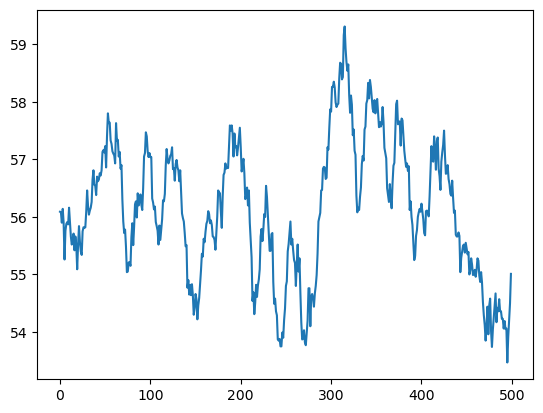

In [246]:
plt.plot(df['49'])
# plt.plot(df['2'])